In [1]:
from typing import Dict, List, Tuple

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Replay buffer

Reference: [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)

In [2]:
class ReplayBuffer:
    """A simple FIFO experience replay buffer for SAC agents."""

    def __init__(self, obs_dim: int, act_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size, self.batch_size = 0, 0, size, batch_size

    def store(self, obs: np.ndarray, act: int, rew: float, next_obs: np.ndarray, done: bool):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self):
        return self.size

## Network

In [3]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        return self.layers(x)

## DQN Agent

In [17]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        update_period (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        cnt_update (int): number of updates
        transition (list): transition information including state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        update_period: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        gamma: float = 0.99, 
        lr: float = 1e-4
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            update_period (int): period for target model's hard update
            epsilon (float): parameter for epsilon greedy policy
            gamma (float): discount factor
            lr (float): learning rate
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, 1, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.update_period = update_period
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)

        # counter
        self.cnt_update = 0
        
        # transition to store in memory
        self.transition = list()

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input space."""
        self.transition = [state]
        
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            state = torch.FloatTensor(state).to(self.device)
            selected_action = self.dqn(state).argmax()
            selected_action = selected_action.detach().cpu().numpy()
            
        self.transition.append(selected_action)
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        self.transition += [reward, next_state, done]
        self.memory.store(*self.transition)
    
        return next_state, reward, done

    def compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        state = torch.FloatTensor(samples["obs"]).to(self.device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(self.device)
        action = torch.LongTensor(samples["acts"]).to(self.device)
        reward = torch.FloatTensor(samples["rews"]).to(self.device)
        done = torch.FloatTensor(samples["done"]).to(self.device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        mask = 1 - done
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1)[0]
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dq loss
        dq_loss = F.smooth_l1_loss(curr_q_value, target.detach())

        return dq_loss

    def update_model(self) -> torch.Tensor:
        """Train the model after each episode."""
        samples = self.memory.sample_batch()

        loss = self.compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_net(self):
        """Update target network's weights."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        losses = []
        all_rewards = []
        epsilons = []
        episode_reward = 0

        state = self.env.reset()
        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            episode_reward += reward

            if done:
                state = env.reset()
                all_rewards.append(episode_reward)
                episode_reward = 0

            if len(self.memory) > self.batch_size:
                self.cnt_update += 1
                loss = self.update_model()
                losses.append(loss)
                
                # decrease epsilon
                self.epsilon = max(
                    self.epsilon - (self.max_epsilon - self.min_epsilon) * self.epsilon_decay,
                    self.min_epsilon,
                )
                
                epsilons.append(self.epsilon)
                
            if self.cnt_update % self.update_period == 0:
                self.update_target_net()

            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, all_rewards, losses, epsilons)
                
    def _plot(self, frame_idx: int, rewards: List[float], losses: List[float], epsilons: List[float]):
        """Plot the training progress."""
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

## Training

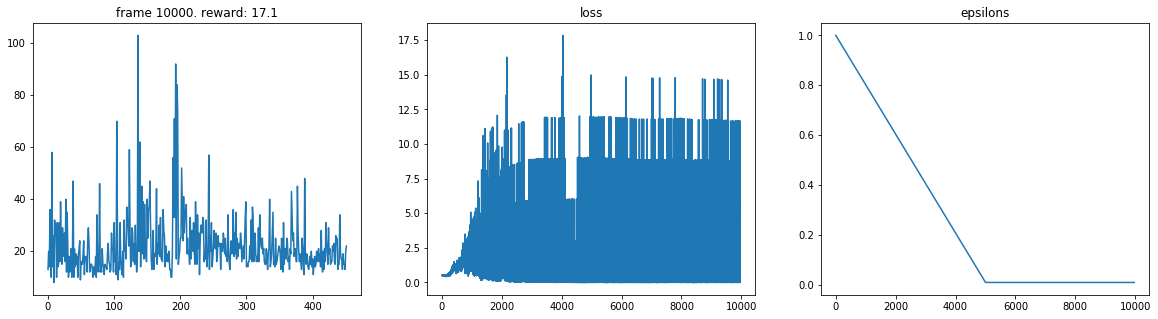

In [19]:
# environment
env_id = "CartPole-v0"
env = gym.make(env_id)

# parameters
num_frames = 10000
memory_size = 100
batch_size = 32
update_period = 10
epsilon_decay = 2 / num_frames

# train
agent = DQNAgent(env, memory_size, batch_size, update_period, epsilon_decay)
agent.train(num_frames)